# AEevents moment tensor inversion

2022.05.09 Kurama Okubo

2022.05.15 update P and S pick

2022.07.29 update for response removal

2022.12.05 update for removal response with preamp, AE sensor and the source factor obtained from the ball drop.We deplicated the emperical gain factor.

2022.12.07 update for the weight of VR; weight on the sensors with large source distance. Update fixing the cc_shift to avoid discrete jump
in the VR due to the cycle skipping.

2023.10.23 update for fb03-087. Cleaned up the notebook.

2023.11.29 Clean up the notebook for multiple events. Save the python script to loop all the events.

2024.2.6 update for master plot. Consider the aperture effect. Correct the $\sqrt{2}$ factor on the seismic moment.

2024.2.7 We checked the reproducivility with model 2, with old sensor coupling coefficient

2024.10.31 update for the merged catalog. As it includes a wider magnitude range, we re-tune the processing parameters.
**Updated**
1. The Pwinlen: `param["Pwinlen"] = 4e-3 #5e-3 # [ms] window length after the p wave arrival` as the tiny event shows shorter P wave pulse for the closest sensor.
2. Frequency band: ` param["freqmin"] = 0.06e6 #0.06e6 #[Hz]` `param["freqmax"] = 1e6 # #0.6e6 #[Hz] Change the frequency band for tiny events` We increased the maximum frequency range.
3. Disable the `fix_dtshift` to fit with wide range pulse width
4. Decrease the number of sensors from 6 to 4 with the closer sensors as the S/N is not good for the tiny events.

This notebook performs the Gridsearch inversion of source properties.


- 2025.03.17 update for the master analysis. **NOTE** This is the preliminary processing to estimate the source parameter, but NOT used for the scaling analysis. See `ComputeScaling` for the main analysis to evaluate the source parameters of GP event.

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
%matplotlib inline
import glob
from glob import glob
import numpy as np
import mpmath as mp
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import warnings
import time

from multiprocessing import Pool, cpu_count
from obspy.signal.cross_correlation import correlate, xcorr_max

from itertools import combinations

from scipy.spatial.distance import euclidean, correlation

%load_ext autoreload
%autoreload 2

from AEevents_Gridsearch_PS_func import *
from AEevents_plot_func import *

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75
os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion
UTCDateTime.DEFAULT_PRECISION = 8 # increase the time precision


**NOTE** 

We define the seismic moment with the following notations:

$$\hat{M_0} = \sqrt{2}M_0$$
$$M_{ij} = \hat{M_0} m_{ij}, $$
where $M_0$ is the true moment tensor satisfying $M_0=\mu AD$ and $m_{ij}$ is the normalized seismic moment tensor as $\sqrt{m_{ij}^2} = 1$. 
We need the factor of $\sqrt{2}$ to compute the moment tensor $M_{ij}$, which meets the definision of seismic moment and seismic moment tensor ( (Silver and Jordan, 1982; Jost and Herrmann, 1989 eq. 20) as followings:

$$ \left[ \dfrac{\sum_{i,j} M_{ij}^2}{2}\right]^{\frac{1}{2}} =  \left[ \dfrac{\sum_{i,j} (\sqrt{2}M_0 m_{ij}) ^2}{2}\right]^{\frac{1}{2}} = M_0.$$

In this notebook, we optimize $\hat{M_0}$ and $m_{ij}$ by the waveform fitting. Then, we obtain the true seismic moment $M_0 = \hat{M_0}/\sqrt{2}$. 

In [2]:
# rootdir for removal resp analysis
rootdir = "./"

# Event location
eventloc_table = "../data/datacsv/AE_obs_location.csv"

# output datadir
outputdir = "../data/07_DATA_MTinversion"
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
# channel table
channel_finame = '../../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'

# datasheet of incident angle
incidentangle_finame = "../data/datacsv/AEevents_isocoord.csv"


# select balldrop calibration model
balldrop_model=4 # 2 for the model only with SiTj, 4 for the SiTjbeta

if balldrop_model==4:
    aperturecorrection=True
elif balldrop_model==2:
    aperturecorrection=False
else:
    aperturecorrection=False
    
# Path for event location table
datadir = f"../data/06_assemble_gf_model{balldrop_model}"


In [3]:
figdir = "../figure/07_MTinversion"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [4]:
# read event loc
df_eventloc = pd.read_csv(eventloc_table, index_col=0)
df_eventloc["Z"] = 0
df_eventloc["datacase"] = df_eventloc.apply(lambda row: "{}__{:04d}".format(row.exprID, row.name), axis=1)
datacases = df_eventloc["datacase"].values
df_eventloc

,stickslip_id,exprID,origin_time,X,Y,V,Vs,dx_best,dy_best,Z,datacase
gougeevent_id,,,,,,,,,,,
4,3,fb03-087,42.474772,1.7475,0.00505,6200,3600,0.0000,-0.0002,0,fb03-087__0004
9,5,fb03-087,47.662693,1.7425,0.00375,6200,3600,0.0000,0.0000,0,fb03-087__0009
18,8,fb03-087,56.727044,1.7460,0.00375,6200,3600,0.0000,0.0000,0,fb03-087__0018
19,9,fb03-087,59.103175,1.7425,0.00300,6200,3600,0.0000,0.0000,0,fb03-087__0019
20,9,fb03-087,59.103526,1.7460,0.00325,6200,3600,0.0000,0.0010,0,fb03-087__0020
21,10,fb03-087,63.752300,1.7470,0.00425,6200,3600,0.0000,0.0000,0,fb03-087__0021
24,11,fb03-087,66.186944,1.7420,0.00425,6200,3600,0.0000,0.0000,0,fb03-087__0024
27,14,fb03-087,76.018478,1.7460,0.00245,6200,3600,0.0000,0.0002,0,fb03-087__0027
30,15,fb03-087,79.319850,1.7505,0.01000,6200,3600,0.0000,0.0000,0,fb03-087__0030


In [5]:
# Read Channel Index
df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
AEsensors = list(channel_loc.keys())
# channel_loc

# Select the event

As the number of event can be handled so far, we process the grid search one by one.

In [6]:
print("The list of avilable events:")
for i, s in enumerate(datacases):
    print(i, s)

The list of avilable events:
0 fb03-087__0004
1 fb03-087__0009
2 fb03-087__0018
3 fb03-087__0019
4 fb03-087__0020
5 fb03-087__0021
6 fb03-087__0024
7 fb03-087__0027
8 fb03-087__0030
9 fb03-087__0031
10 fb03-087__0037
11 fb03-087__0038
12 fb03-087__0040
13 fb03-087__0043
14 fb03-087__0044
15 fb03-087__0049
16 fb03-087__0050
17 fb03-087__0052
18 fb03-087__0055
19 fb03-087__0059
20 fb03-087__0061
21 fb03-087__0062
22 fb03-087__0069
23 fb03-087__0072
24 fb03-087__0075
25 fb03-087__0076
26 fb03-087__0077
27 fb03-087__0081
28 fb03-087__0085
29 fb03-087__0088
30 fb03-087__0089
31 fb03-087__0095
32 fb03-087__0099
33 fb03-087__0100
34 fb03-087__0102
35 fb03-087__0109
36 fb03-087__0110
37 fb03-087__0111
38 fb03-087__0118
39 fb03-087__0120
40 fb03-087__0126
41 fb03-087__0128
42 fb03-087__0129
43 fb03-087__0131


In [7]:
# select event
datacase = datacases[40] #23 #5 # We repeated running the notebook with selecting the datacase to complete the grid search for all the events.
print(f"start processing event {datacase}.")

# load event trace
st_event = read(datadir + "/{}_AEwaveform.pickle".format(datacase)) # this contains observation and green's function within a thresholded distance

start processing event fb03-087__0126.


# Implement Grid search

Here we implement the grid search of M0, rake and TR.

Workflow:
- loop on rake and TR
- synthesize the vz
- correct arrival time: Note that the normalized cc does not change with the amplitude, so perform this process before the loop on M0hat.
- loop M0hat (linear scaling)
- compute variance reduction
- store to pandas


In [8]:
param = {}
param["datacase"] = datacase
param["st_event"] = st_event
param["TR_input"] = 5.0e-6 # set at the input file of OpenSWPC 
param["cp"] = 6200 #6200 # 5560 #6200 #[m/s] dilational wave velocity
param["cs"] = 3600 #3590 #[m/s] shear wave velocity
param["weight_factor"] = 0.1 #2.0 # weight of variance reduction
param["prePwinlen"] = 1e-3 #2e-3 # [ms] window length behind the p wave arrival
param["Pwinlen"] = 4e-3 #3e-3 # [ms] window length after the p wave arrival

param["preSwinlen"] = 6e-3 #7e-3 # [ms] window length behind the p wave arrival
param["Swinlen"] = 4e-3 # [ms] window length after the p wave arrival

param["compute_P"] = True # True if compute residuals within the P wave 
param["compute_S"] = True # True if compute residuals within the S wave 
param["alpha_p"] = 1.0 # weight on P wave  #update: using only P # 0.5 # weight on P wave
param["alpha_s"] = 0.0 # weight on S wave

param["ifFilteringBeforeTrim"] = True
param["freqmin"] = 0.06e6 #[Hz]
param["freqmax"] = 1.0e6 #0.6e6 #[Hz]
param["max_lag_shift"] = 51 # number of time shift for cross-correlation.
param["aperturecorrection"] = aperturecorrection

In [9]:
dist_all = dict()
for tr in st_event.select(location="stage1"):
    dist_all[tr.stats.station] = tr.stats.dist

In [10]:
# select the sensor list (jackknife test)
Nsensor = 4 #6

# deprecated jack knife test 
# jktest_sensorlist = list(combinations(dist_all.keys(),  Nsensor))
# # jktest_sensorlist = [ ('OL14', 'OL15', 'OL30', 'OL31')]
# param["jktest_sensorlist"] = jktest_sensorlist
# jktest_sensorlist
# data = {"sensor":jktest_sensorlist}
# pd.DataFrame(data=data)

# Pre evaluation

In [11]:
# for VR_sensors in jktest_sensorlist:
# param["VR_sensors"] = jktest_sensorlist[0]
sensor_list_mergedcatalog = ('OL07', 'OL08',  'OL23', 'OL22') # we use the 4 sensor, as the far station is not adequate for the tiny events.
param["VR_sensors"] = sensor_list_mergedcatalog

# st_event_trimmed, weight_all = get_retrimmed_traces(0.05, +6.0, 3e-6, param)

#---correct apperture effect---#
M0_test= 0.2
TR_test= 2.6e-6 #3.0e-6

param["df_incidentangle"] = pd.read_csv(incidentangle_finame, index_col=0)
param["R_sensor"] = 6.35e-3 # [m] radius of AE sensor
# debug
AEid = "OL07"
df_incidentangle_sensor = param["df_incidentangle"].loc[f"{AEid}__{datacase}"]
# param["df_incidentangle"]
df_incidentangle_sensor

OL                           OL07
datacase           fb03-087__0126
xs                           1.66
ys                           0.05
zs                           0.07
xi                          1.744
eta                       -0.0005
zeta                            0
xi1                         0.084
eta1                      -0.0505
zeta1                           0
incidentangle           65.210273
azimuth                 58.986116
rlen_sourcedist          0.120442
llen                     0.098011
Name: OL07__fb03-087__0126, dtype: object

In [12]:
# Compute amplitude response with incident angle
def incidentangle_scalingfactor_analytic(v, theta, TR, R):
    if theta==0:
        return 1.0
    else:
        va = v/np.sin(theta)
        J1 = mp.besselj(1, (2*np.pi*R)/(va*TR))
        return  ((va * TR)/(np.pi*R)) * J1

In [13]:
# float(incidentangle_scalingfactor_analytic(param["cp"], np.deg2rad(df_incidentangle_sensor["incidentangle"]), TR_test, param["R_sensor"]))

In [14]:
st_event_trimmed = get_retrimmed_traces(M0_test, 0.0, TR_test, param, aperturecorrection=aperturecorrection)

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.488525
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.439518
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.536657
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.428129


In [15]:
dist_all

# sort by source distance
# df_dist_filtered = { k: dist_all[k] for k in jktest_sensorlist[0]}
df_dist_filtered = { k: dist_all[k] for k in sensor_list_mergedcatalog}
df_dist_sorted = {k: v for k, v in sorted(df_dist_filtered.items(), key=lambda item: item[1])}
param["df_dist_sorted"] = df_dist_sorted

In [16]:
df_dist_sorted

{'OL23': 95.03288904374104,
 'OL07': 120.44189470445909,
 'OL08': 187.0995724206765,
 'OL22': 225.90097388014962}

3e-07
(array([0.4886949 , 0.37904801]), {'nfev': 11, 'fjac': array([[-0.99999888,  0.00149639],
       [-0.00149639, -0.99999888]]), 'r': array([-0.24750027, -0.99999928, -0.0012145 ]), 'qtf': array([-8.62982078e-17,  5.76707225e-14]), 'fvec': array([0.00000000e+00, 1.21972744e-19])}, 1, 'The solution converged.')
(array([0.79384284, 0.3035239 ]), {'nfev': 11, 'fjac': array([[-0.99999876,  0.00157716],
       [-0.00157716, -0.99999876]]), 'r': array([-0.24750031, -0.99999832, -0.00185652]), 'qtf': array([-7.60399952e-17,  4.82132316e-14]), 'fvec': array([ 0.00000000e+00, -1.08420217e-19])}, 1, 'The solution converged.')
29.22627468036765 14.301395916774943
2e-07
(array([0.45609213, 0.38483674]), {'nfev': 10, 'fjac': array([[-0.9999986 ,  0.00167535],
       [-0.00167535, -0.9999986 ]]), 'r': array([-0.25250036, -0.99999937, -0.00123147]), 'qtf': array([-2.50799363e-15,  1.43072560e-12]), 'fvec': array([ 0.00000000e+00, -4.60785923e-19])}, 1, 'The solution converged.')
(array([0.8110093

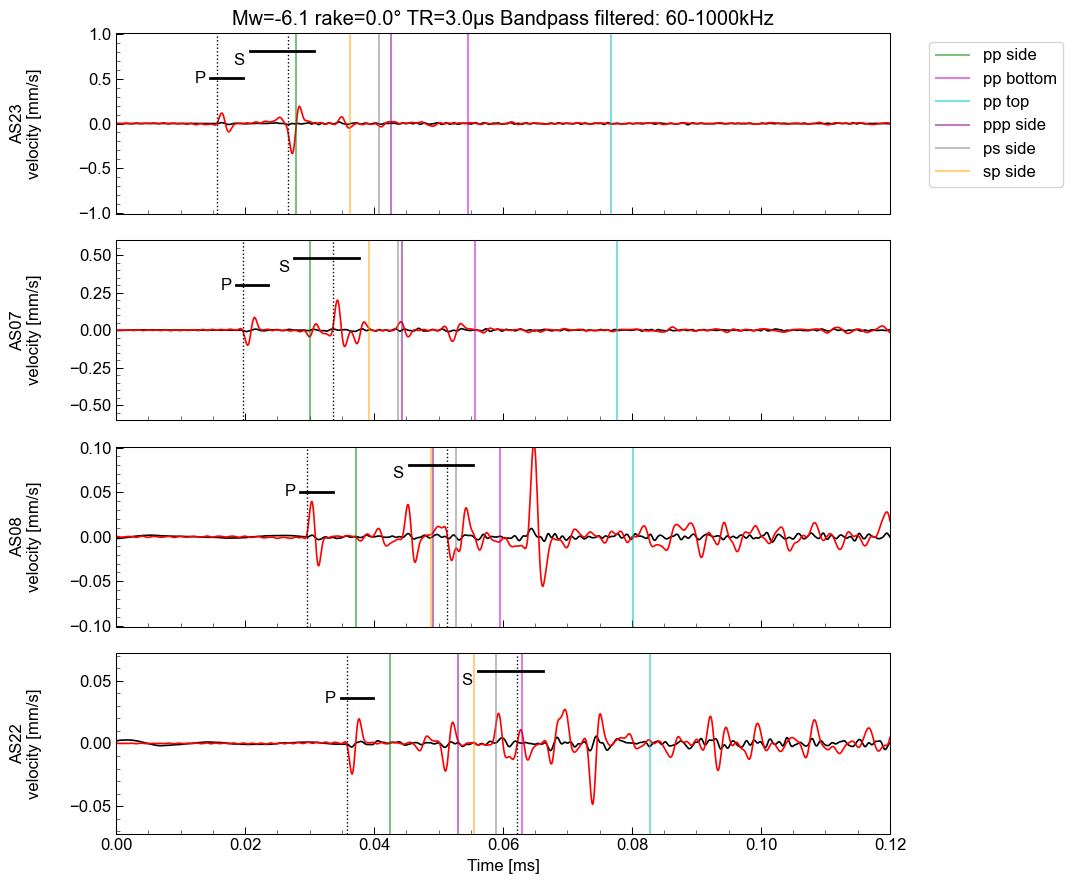

In [17]:
# plot comparison of waveform
# NOTE: tr_filt includes pretigger, while tr_retrimmed is retrimmed without pretigger. Thus, correct pretrigger only on the filter (entire) trace.
# pwin_st, pwin_et does not contain the pretrigger. 

param["TR"]= 3.0e-6
param["Mw"] = M02Mw(0.8)
param["rake"] = 0

param["plot_reflection"] = True
AE_GridSearch_plot_raw(st_event_trimmed, param)
# AE_GridSearch_plot_shifted(sensorgain_coef, st_event_trimmed, param)

plt.tight_layout()
plt.savefig(figdir + "/waveform_raw_{}_reflection_{}.png".format(datacase, param["plot_reflection"]), dpi=400)

In [18]:
tr_obs = st_event_trimmed.select(location="Retrim_P", channel="OZ")[1]
tr_syn = st_event_trimmed.select(location="Retrim_P", channel="VZ")[1]
cc = tr_syn.stats.cc
# tr_obs.stats

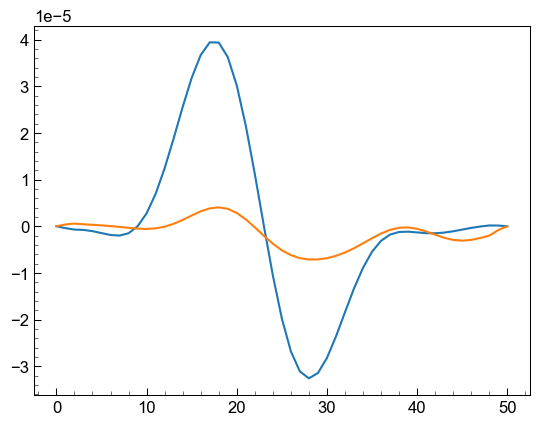

In [19]:
plt.plot(tr_syn.taper(0.05))
plt.plot(tr_obs.taper(0.05))

In [20]:
cc = correlate(tr_obs.taper(0.1), tr_syn.taper(0.1), 601, demean=True) # the order is 1. obs and 2. syn

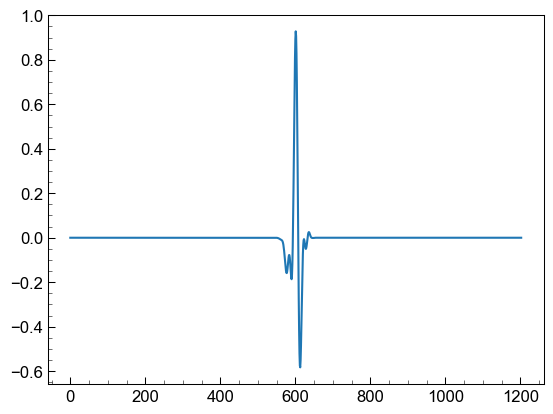

In [21]:
plt.plot(cc)

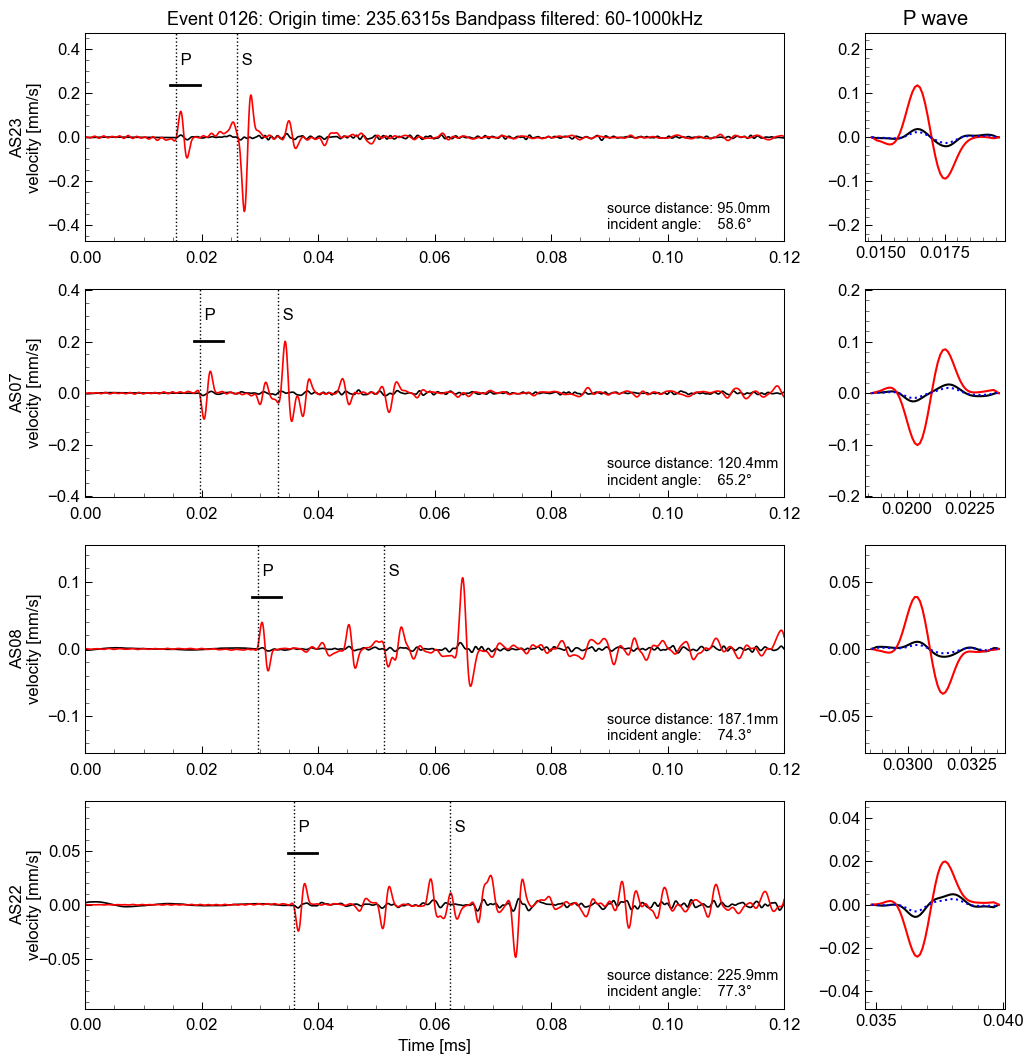

In [22]:
# plot shifted traces
AE_GridSearch_plot_entirewaveform_withP(st_event_trimmed, param)
plt.tight_layout()
plt.savefig(figdir + "/waveform_compare_preeval_{}".format(datacase), dpi=400)

# Fix the shift of P and S window
To avoid the jump of VR due to cycle skipping, we fix the P and S window with referenced set of source parameters.
The reference source parameters are obtained from the test trial without fixing the dt_shift (i.e., `fix_dtshift=False`) at first.

We could also get the reference source parameters from the evaluation only in P wave window without fixing the dt_shift, as the waveform is simpler enough to obtain the crude estimation of the source parameters in P wave window.

In [23]:
param["VR_sensors"] = sensor_list_mergedcatalog
param["ref_M0hat"] = 0.5 #0.052
param["ref_TR"] = 3.0e-6 #3.5e-6
param["ref_rake"] = 0.0

st_event_trimmed_ref = get_retrimmed_traces(param["ref_M0hat"], param["ref_rake"], param["ref_TR"], param, aperturecorrection=aperturecorrection)

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.595213
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.553536
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.635513
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.543750


In [24]:
cc1 = st_event_trimmed_ref.select(station = "OL07", location="Retrim_*", channel="VZ")[0].stats.cc.max()
cc2 = st_event_trimmed_ref.select(station = "OL07", location="Retrim_*", channel="VZ")[1].stats.cc.max()

cc1, cc2

(0.9288570361742824, 0.5417042747273718)

In [25]:
param["fix_dtshift"] = dict()

# Here, we stay with the st_event_trimmed, not st_event_trimmed_ref as we used similar M0test and TRtest.
for stnm in param["VR_sensors"]:
    dt_shift_p = st_event_trimmed.select(station=stnm, location="Retrim_P", channel="VZ")[0].stats.dt_shift
    dt_shift_s = st_event_trimmed.select(station=stnm, location="Retrim_S", channel="VZ")[0].stats.dt_shift
    param["fix_dtshift"][stnm] = [dt_shift_p, dt_shift_s]

In [26]:
param["fix_dtshift"]["OL08"][0]

-6e-07

In [27]:
# To better adjust the different pulse width, we turn off the fix_dtshift
param["fix_dtshift"] = []
if not param["fix_dtshift"]:
    print(1)

1


# Grid search of residuals

## The weight with the absolute maximum amplitude
The standard variance reduction normalize the residual by the observations. Then, it inherently indicates that a weight is applied on the small amplitude. To focus on the similarity in large amplitude, one can choose

1. use the euclidean distance as weight, or normalize the amplitude with the synthetic data
2. use the explicit weight.

However, in the case of gouge patch, **we obtain the good fitting without weight.** Thus, we simply assign the uniform weight as $\dfrac{1}{N_\text{sensor}}$.

In [28]:
Mw2M0(-6.7)

0.11350108156723143

In [29]:
# Updated for the merged catalog
M0hat_range = np.logspace(np.log10(0.001), np.log10(2.0), 101) #31) # M0hat with 0.02 [J] grid
Mw_range = M02Mw(M0hat_range)
rake_range = np.array([0]) # fix to parallel to the slip
TR_range   = np.arange(1.0e-6, 4.0e-6, 0.1e-6) # [s] TR with 0.1 microsec grid


In [30]:
print("{:.2g}".format(M0hat_range[0]/np.sqrt(2)))
print(0.02/np.sqrt(2))

0.00071
0.014142135623730949


In [31]:
M0hat_range, rake_range, TR_range

(array([1.00000000e-03, 1.07897231e-03, 1.16418125e-03, 1.25611933e-03,
        1.35531798e-03, 1.46235057e-03, 1.57783578e-03, 1.70244112e-03,
        1.83688683e-03, 1.98195003e-03, 2.13846920e-03, 2.30734906e-03,
        2.48956574e-03, 2.68617250e-03, 2.89830576e-03, 3.12719166e-03,
        3.37415321e-03, 3.64061789e-03, 3.92812590e-03, 4.23833909e-03,
        4.57305052e-03, 4.93419489e-03, 5.32385966e-03, 5.74429717e-03,
        6.19793759e-03, 6.68740305e-03, 7.21552273e-03, 7.78534923e-03,
        8.40017626e-03, 9.06355759e-03, 9.77932769e-03, 1.05516238e-02,
        1.13849099e-02, 1.22840026e-02, 1.32540986e-02, 1.43008054e-02,
        1.54301731e-02, 1.66487295e-02, 1.79635182e-02, 1.93821388e-02,
        2.09127911e-02, 2.25643225e-02, 2.43462792e-02, 2.62689611e-02,
        2.83434817e-02, 3.05818320e-02, 3.29969499e-02, 3.56027954e-02,
        3.84144304e-02, 4.14481068e-02, 4.47213595e-02, 4.82531087e-02,
        5.20637682e-02, 5.61753643e-02, 6.06116627e-02, 6.539830

# Weight of sensors to compute the VR 



<!-- We use the weight of sensors for the variance reduction based on the S/N ratio and the source distance.
We compute the S/N by
$$S/N = \dfrac{max(u_{Pwin})}{std(u_{noise}(t))}.$$

Then, the weight of sensor $i$ is computed as
$$w_i = r^\alpha \exp{(\beta S/N)},$$ 
where $r$ is the source distance and $\alpha$ is the factor to control the dependency of source distance.
The weight is then normalized for its summation to be unity. -->

We would define the weight as
<!-- 
$$w_i = \dfrac{\exp{(\alpha~max(cc_i) + \beta r_i)}}{\sum_k^N \exp{(\alpha~max(cc_i) + \beta r_i)}}$$ 
 -->
 
<!-- $$w_i = \dfrac{\exp{(\alpha r_i)}}{\sum_k^N \exp{(\alpha r_i)}}$$  -->
$$w_i = \dfrac{\exp{(\alpha~max(cc_i) + \beta r_i)}}{\sum_k^N \exp{(\alpha~max(cc_i) + \beta r_i)}}$$ 

However, in the case of fb03-087 we use the uniform weight, i.e., $\alpha = \beta = 0$.
To exclude the sensors with low similarity (e.g. station far from the source), we set the threshold in the max value of the correlation function normalized with the std of waveform (normalize="naive" in `obspy.signal.cross_correlation.correlate`).


aperture correct: OL07 incident angle=65.210273deg. beta_p=0.595213
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.553536
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.635513
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.543750


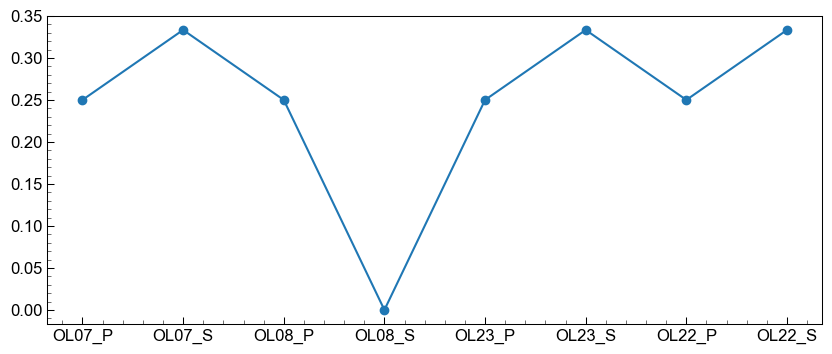

In [32]:
def compute_weight_VR(st_event_trimmed, VR_sensors, weight_cc, weight_VR, cc_threshold=0.5):
    weight_P_tmp = dict()
    weight_S_tmp = dict()
    weight_PS_normalized = dict()
    
    for stnm in VR_sensors:
        tr_obs_filt = st_event_trimmed.select(location="Filt", channel="OZ", station=stnm)[0] # evaluate S/N after bandpass filtering
        tr_syn_Retrim_P = st_event_trimmed.select(location="Retrim_P", channel="VZ", station=stnm)[0] 
        tr_syn_Retrim_S = st_event_trimmed.select(location="Retrim_S", channel="VZ", station=stnm)[0] 
#         print(tr_syn_Retrim_P, tr_syn_Retrim_S)
        ccmax_P = tr_syn_Retrim_P.stats.cc.max()
        ccmax_S = tr_syn_Retrim_S.stats.cc.max()
        
        if ccmax_P>cc_threshold:
            weight_P_tmp[stnm] = np.exp(weight_cc * ccmax_P + tr_obs_filt.stats.dist * weight_VR)
        else:
            weight_P_tmp[stnm] = 0
            
        
        if ccmax_S>cc_threshold:
            weight_S_tmp[stnm] = np.exp(weight_cc * ccmax_S + tr_obs_filt.stats.dist * weight_VR)
        else:
            weight_S_tmp[stnm] = 0

    sum_weight_exp_P = sum(weight_P_tmp.values())
    sum_weight_exp_S = sum(weight_S_tmp.values())

    for stnm in VR_sensors:
        weight_PS_normalized[stnm+"_P"] = weight_P_tmp[stnm] / sum_weight_exp_P
        weight_PS_normalized[stnm+"_S"] = weight_S_tmp[stnm] / sum_weight_exp_S

    return weight_PS_normalized



# compute weight with reference source parameters
VR_sensors = sensor_list_mergedcatalog #jktest_sensorlist[0]
weight_cc = 0 # for uniform weight
weight_VR = 0 # for uniform weight

st_event_trimmed = get_retrimmed_traces(param["ref_M0hat"], param["ref_rake"], param["ref_TR"], param, aperturecorrection=aperturecorrection)

# st_event_trimmed = get_retrimmed_traces(1.0, 0.0, 3e-6, param) # obtain the bandpassed & trimmed traces
weight_PS_normalized = compute_weight_VR(st_event_trimmed, VR_sensors, weight_cc, weight_VR, cc_threshold=0.5)

x, y = zip(*weight_PS_normalized.items())
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(x, y, "o-")


In [33]:
weight_PS_normalized

{'OL07_P': 0.25,
 'OL07_S': 0.3333333333333333,
 'OL08_P': 0.25,
 'OL08_S': 0.0,
 'OL23_P': 0.25,
 'OL23_S': 0.3333333333333333,
 'OL22_P': 0.25,
 'OL22_S': 0.3333333333333333}

In [34]:
df_VR_all = pd.DataFrame(columns = ["Mw", "M0hat", "M0", "rake", "TR", "VR_P", "VR_S", "VR_PS", "VR_sensors", "Nsensor"])

# select the sensor list (jackknife test)
Nsensor = 6
jktest_sensorlist = list(combinations(dist_all.keys(),  Nsensor))
jktest_sensorlist

df_comp_all_p = pd.DataFrame()
df_comp_all_s = pd.DataFrame()

weight_VR = 0.01 #0.015

# start grid search
# for VR_sensors in jktest_sensorlist:
for rake_try in rake_range: # loop by rake
    for TR_try in tqdm(TR_range): # loop by TR
#         print(rake_try, TR_try)
        VR_sensors = sensor_list_mergedcatalog #jktest_sensorlist[0]

        param["VR_sensors"] = VR_sensors
        
        #---Correction of aperture effect---#
        
        #-----------------------------------#
        
        # synthesize the traces with M0hat = 1.0; this is scaled again with the later loop on the M0hat_range 
        st_event_trimmed = get_retrimmed_traces(1.0, rake_try, TR_try, param, fix_dtshift=False, aperturecorrection=aperturecorrection)

#         weight_normalized = compute_weight_VR(st_event_trimmed, VR_sensors, weight_VR)

        for ind_M0, M0hat_try in enumerate(M0hat_range): # loop by M0
        #--------------------------------------------------------------------#
        #---Compute the variance reduction--#
        #--------------------------------------------------------------------#   

            VR_P, VR_S, VR_PS, VR_comp_p, VR_comp_s  = compute_VR(M0hat_try, st_event_trimmed, VR_sensors, weight_PS_normalized, param)
            
            df_comp_tmp_p = dict()
            df_comp_tmp_s = dict()
            for stnm in VR_sensors:
                df_comp_tmp_p[stnm] = [VR_comp_p[stnm]]
                df_comp_tmp_s[stnm] = [VR_comp_s[stnm]]
            
            df_comp_tmp_p["M0hat"] = M0hat_try
            df_comp_tmp_s["M0hat"] = M0hat_try
            df_comp_tmp_p["M0"] = M0hat_try/np.sqrt(2)
            df_comp_tmp_s["M0"] = M0hat_try/np.sqrt(2)
            df_comp_tmp_p["TR"] = TR_try
            df_comp_tmp_s["TR"] = TR_try
            df_comp_tmp_p["rake"] = rake_try
            df_comp_tmp_s["rake"] = rake_try
            
            df_comp_all_p = pd.concat([df_comp_all_p, pd.DataFrame.from_dict(df_comp_tmp_p)])
            df_comp_all_s = pd.concat([df_comp_all_s, pd.DataFrame.from_dict(df_comp_tmp_s)])
                
            # store to DataFrame
            d_VR = {"Mw": [Mw_range[ind_M0]], "M0hat":[M0hat_try], "M0":[M0hat_try/np.sqrt(2)], "rake":[rake_try], 
                    "TR":[TR_try], "VR_P":[VR_P], "VR_S":[VR_S], "VR_PS":[VR_PS], "VR_sensors":[VR_sensors], "Nsensor":[Nsensor]}
            df_VR_all = pd.concat([df_VR_all, pd.DataFrame.from_dict(d_VR)])
                

  0%|                                                    | 0/31 [00:00<?, ?it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=-0.104292
aperture correct: OL08 incident angle=74.341103deg. beta_p=-0.075459
aperture correct: OL23 incident angle=58.609218deg. beta_p=-0.124443


/var/folders/6n/nsqc1sbn1kn5ccc7y51plgz00000gn/T/ipykernel_91572/881127193.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_VR_all = pd.concat([df_VR_all, pd.DataFrame.from_dict(d_VR)])


aperture correct: OL22 incident angle=77.342498deg. beta_p=-0.068005


  3%|█▍                                          | 1/31 [00:00<00:24,  1.25it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=-0.130315
aperture correct: OL08 incident angle=74.341103deg. beta_p=-0.117627
aperture correct: OL23 incident angle=58.609218deg. beta_p=-0.130916
aperture correct: OL22 incident angle=77.342498deg. beta_p=-0.113246


  6%|██▊                                         | 2/31 [00:01<00:22,  1.27it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=-0.127328
aperture correct: OL08 incident angle=74.341103deg. beta_p=-0.132228
aperture correct: OL23 incident angle=58.609218deg. beta_p=-0.109719
aperture correct: OL22 incident angle=77.342498deg. beta_p=-0.131673


 10%|████▎                                       | 3/31 [00:02<00:21,  1.28it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=-0.102110
aperture correct: OL08 incident angle=74.341103deg. beta_p=-0.122664
aperture correct: OL23 incident angle=58.609218deg. beta_p=-0.069755
aperture correct: OL22 incident angle=77.342498deg. beta_p=-0.125750


 13%|█████▋                                      | 4/31 [00:03<00:21,  1.28it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=-0.061968
aperture correct: OL08 incident angle=74.341103deg. beta_p=-0.095066
aperture correct: OL23 incident angle=58.609218deg. beta_p=-0.018656
aperture correct: OL22 incident angle=77.342498deg. beta_p=-0.101209


 16%|███████                                     | 5/31 [00:03<00:20,  1.28it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=-0.012936
aperture correct: OL08 incident angle=74.341103deg. beta_p=-0.055396
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.037963
aperture correct: OL22 incident angle=77.342498deg. beta_p=-0.063916


 19%|████████▌                                   | 6/31 [00:04<00:19,  1.29it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.040542
aperture correct: OL08 incident angle=74.341103deg. beta_p=-0.008484
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.096298
aperture correct: OL22 incident angle=77.342498deg. beta_p=-0.018746


 23%|█████████▉                                  | 7/31 [00:05<00:18,  1.28it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.095409
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.042092
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.153923
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.030628


 26%|███████████▎                                | 8/31 [00:06<00:17,  1.29it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.149664
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.093831
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.209375
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.081597


 29%|████████████▊                               | 9/31 [00:07<00:17,  1.29it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.202067
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.145061
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.261847
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.132394


 32%|█████████████▊                             | 10/31 [00:07<00:16,  1.28it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.251901
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.194714
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.310952
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.181869


 35%|███████████████▎                           | 11/31 [00:08<00:15,  1.28it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.298801
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.242150
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.356574
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.229315


 39%|████████████████▋                          | 12/31 [00:09<00:16,  1.12it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.342629
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.287020
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.398761
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.274333


 42%|██████████████████                         | 13/31 [00:10<00:15,  1.13it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.383395
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.329176
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.437657
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.316734


 45%|███████████████████▍                       | 14/31 [00:11<00:14,  1.14it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.421195
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.368595
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.473457
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.356465


 48%|████████████████████▊                      | 15/31 [00:12<00:13,  1.16it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.456180
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.405339
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.506382
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.393566


 52%|██████████████████████▏                    | 16/31 [00:13<00:12,  1.19it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.488525
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.439518
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.536657
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.428129


 55%|███████████████████████▌                   | 17/31 [00:13<00:11,  1.19it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.518417
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.471273
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.564504
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.460283


 58%|████████████████████████▉                  | 18/31 [00:14<00:10,  1.22it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.546043
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.500756
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.590133
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.490170


 61%|██████████████████████████▎                | 19/31 [00:15<00:10,  1.18it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.571584
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.528125
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.613742
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.517943


 65%|███████████████████████████▋               | 20/31 [00:16<00:09,  1.17it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.595213
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.553536
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.635513
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.543750


 68%|█████████████████████████████▏             | 21/31 [00:17<00:08,  1.18it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.617090
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.577139
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.655611
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.567740


 71%|██████████████████████████████▌            | 22/31 [00:18<00:07,  1.18it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.637365
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.599075
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.674189
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.590052


 74%|███████████████████████████████▉           | 23/31 [00:18<00:06,  1.19it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.656174
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.619478
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.691384
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.610817


 77%|█████████████████████████████████▎         | 24/31 [00:19<00:05,  1.18it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.673643
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.638471
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.707320
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.630158


 81%|██████████████████████████████████▋        | 25/31 [00:20<00:05,  1.16it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.689886
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.656167
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.722110
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.648188


 84%|████████████████████████████████████       | 26/31 [00:21<00:04,  1.16it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.705006
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.672672
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.735853
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.665012


 87%|█████████████████████████████████████▍     | 27/31 [00:22<00:03,  1.19it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.719098
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.688082
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.748642
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.680726


 90%|██████████████████████████████████████▊    | 28/31 [00:23<00:02,  1.22it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.732248
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.702483
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.760558
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.695418


 94%|████████████████████████████████████████▏  | 29/31 [00:23<00:01,  1.23it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.744533
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.715957
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.771676
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.709168


 97%|█████████████████████████████████████████▌ | 30/31 [00:24<00:00,  1.23it/s]

aperture correct: OL07 incident angle=65.210273deg. beta_p=0.756023
aperture correct: OL08 incident angle=74.341103deg. beta_p=0.728577
aperture correct: OL23 incident angle=58.609218deg. beta_p=0.782062
aperture correct: OL22 incident angle=77.342498deg. beta_p=0.722051


100%|███████████████████████████████████████████| 31/31 [00:25<00:00,  1.21it/s]


In [35]:
# weight_normalized

In [36]:
# ax1 = df_comp_all_p.plot(kind='scatter',x="M0", y="OL15", color='r', marker="^")    
# ax2 = df_comp_all_p.plot(kind='scatter',x="M0", y="OL30", color='b', ax=ax1)    
# # ax3 = df_comp_all_p.plot(kind='scatter',x="M0", y="OL30", color='g', ax=ax1, marker="+")    
# # ax4 = df_comp_all_p.plot(kind='scatter',x="M0", y="OL31", color='c', ax=ax1, marker=".")    

In [37]:
M0hat_range, TR_range, rake_range

(array([1.00000000e-03, 1.07897231e-03, 1.16418125e-03, 1.25611933e-03,
        1.35531798e-03, 1.46235057e-03, 1.57783578e-03, 1.70244112e-03,
        1.83688683e-03, 1.98195003e-03, 2.13846920e-03, 2.30734906e-03,
        2.48956574e-03, 2.68617250e-03, 2.89830576e-03, 3.12719166e-03,
        3.37415321e-03, 3.64061789e-03, 3.92812590e-03, 4.23833909e-03,
        4.57305052e-03, 4.93419489e-03, 5.32385966e-03, 5.74429717e-03,
        6.19793759e-03, 6.68740305e-03, 7.21552273e-03, 7.78534923e-03,
        8.40017626e-03, 9.06355759e-03, 9.77932769e-03, 1.05516238e-02,
        1.13849099e-02, 1.22840026e-02, 1.32540986e-02, 1.43008054e-02,
        1.54301731e-02, 1.66487295e-02, 1.79635182e-02, 1.93821388e-02,
        2.09127911e-02, 2.25643225e-02, 2.43462792e-02, 2.62689611e-02,
        2.83434817e-02, 3.05818320e-02, 3.29969499e-02, 3.56027954e-02,
        3.84144304e-02, 4.14481068e-02, 4.47213595e-02, 4.82531087e-02,
        5.20637682e-02, 5.61753643e-02, 6.06116627e-02, 6.539830

In [38]:
df_VR_all

,Mw,M0hat,M0,rake,TR,VR_P,VR_S,VR_PS,VR_sensors,Nsensor
0,-8.070000,0.001000,0.000707,0,0.000001,-0.017256,0.152769,-0.017256,"(OL07, OL08, OL23, OL22)",6
0,-8.047993,0.001079,0.000763,0,0.000001,-0.018629,0.162186,-0.018629,"(OL07, OL08, OL23, OL22)",6
0,-8.025986,0.001164,0.000823,0,0.000001,-0.020113,0.171913,-0.020113,"(OL07, OL08, OL23, OL22)",6
0,-8.003979,0.001256,0.000888,0,0.000001,-0.021716,0.181902,-0.021716,"(OL07, OL08, OL23, OL22)",6
0,-7.981973,0.001355,0.000958,0,0.000001,-0.023447,0.192091,-0.023447,"(OL07, OL08, OL23, OL22)",6
...,...,...,...,...,...,...,...,...,...,...
0,-5.957341,1.475668,1.043455,0,0.000004,-1200.779757,-8112.922663,-1200.779757,"(OL07, OL08, OL23, OL22)",6
0,-5.935334,1.592205,1.125859,0,0.000004,-1403.083881,-9453.955683,-1403.083881,"(OL07, OL08, OL23, OL22)",6
0,-5.913327,1.717946,1.214771,0,0.000004,-1639.009936,-11015.875344,-1639.009936,"(OL07, OL08, OL23, OL22)",6
0,-5.891320,1.853616,1.310704,0,0.000004,-1914.110184,-12835.003491,-1914.110184,"(OL07, OL08, OL23, OL22)",6


In [39]:
df_1 = df_VR_all[df_VR_all["rake"] == 0]
df_1

,Mw,M0hat,M0,rake,TR,VR_P,VR_S,VR_PS,VR_sensors,Nsensor
0,-8.070000,0.001000,0.000707,0,0.000001,-0.017256,0.152769,-0.017256,"(OL07, OL08, OL23, OL22)",6
0,-8.047993,0.001079,0.000763,0,0.000001,-0.018629,0.162186,-0.018629,"(OL07, OL08, OL23, OL22)",6
0,-8.025986,0.001164,0.000823,0,0.000001,-0.020113,0.171913,-0.020113,"(OL07, OL08, OL23, OL22)",6
0,-8.003979,0.001256,0.000888,0,0.000001,-0.021716,0.181902,-0.021716,"(OL07, OL08, OL23, OL22)",6
0,-7.981973,0.001355,0.000958,0,0.000001,-0.023447,0.192091,-0.023447,"(OL07, OL08, OL23, OL22)",6
...,...,...,...,...,...,...,...,...,...,...
0,-5.957341,1.475668,1.043455,0,0.000004,-1200.779757,-8112.922663,-1200.779757,"(OL07, OL08, OL23, OL22)",6
0,-5.935334,1.592205,1.125859,0,0.000004,-1403.083881,-9453.955683,-1403.083881,"(OL07, OL08, OL23, OL22)",6
0,-5.913327,1.717946,1.214771,0,0.000004,-1639.009936,-11015.875344,-1639.009936,"(OL07, OL08, OL23, OL22)",6
0,-5.891320,1.853616,1.310704,0,0.000004,-1914.110184,-12835.003491,-1914.110184,"(OL07, OL08, OL23, OL22)",6


<Axes: xlabel='TR'>

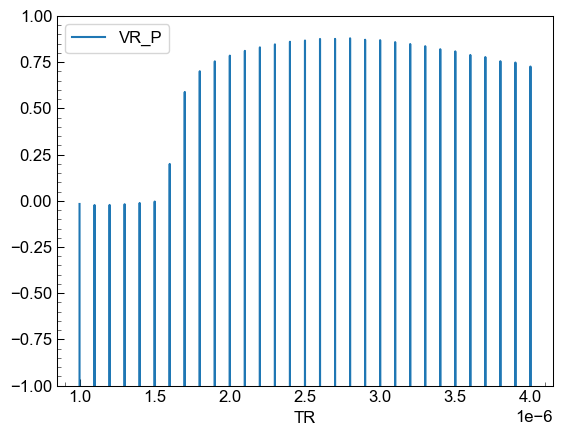

In [40]:
# check the continuity of VR
df_1.plot(x="TR", y="VR_P", ylim=[-1, 1])


In [41]:
zc_P = np.zeros((len(M0hat_range), len(TR_range)))
zc_S = np.zeros((len(M0hat_range), len(TR_range)))
zc_PS = np.zeros((len(M0hat_range), len(TR_range)))

for i, M0hat_try in enumerate(tqdm(M0hat_range)): # loop by M0
    for j, TR_try in enumerate(TR_range):
        
        df_select = df_VR_all[(df_VR_all["M0hat"] == M0hat_try) & (df_VR_all["TR"] == TR_try)]
        
        imax_P = df_select["VR_P"].argmax()
        imax_S = df_select["VR_S"].argmax()
        imax_PS = df_select["VR_PS"].argmax()
        
        VR_P_max = df_select.iloc[imax_P]["VR_P"]
        VR_S_max = df_select.iloc[imax_S]["VR_S"]
        VR_PS_max = df_select.iloc[imax_PS]["VR_PS"]
              
        zc_P[i, j] =  VR_P_max
        zc_S[i, j] =  VR_S_max
        zc_PS[i, j] =  VR_PS_max
        

100%|████████████████████████████████████████| 101/101 [00:00<00:00, 127.58it/s]


In [42]:
df_select["VR_P"]

0   -2234.851007
Name: VR_P, dtype: float64

In [43]:
max_M0hat_PS, max_TR_PS = np.unravel_index(zc_PS.argmax(), zc_PS.shape)
best_M0hat_PS = M0hat_range[max_M0hat_PS]
best_M0_PS = M0hat_range[max_M0hat_PS]/np.sqrt(2)
best_TR_PS = TR_range[max_TR_PS]
df_best_PS = df_VR_all[(df_VR_all["M0hat"] == best_M0hat_PS) & (df_VR_all["TR"] == best_TR_PS)]

print(f"best M0hat:{best_M0hat_PS:.3f} M0:{best_M0_PS:.3f}, best TR:{best_TR_PS:.2e}")

best M0hat:0.033 M0:0.023, best TR:2.80e-06


In [44]:
np.round(best_M0_PS, 5), np.round(best_TR_PS*1e6, 5)

(0.02333, 2.8)

In [45]:
zc_PS.max()

0.8792359452740103

/var/folders/6n/nsqc1sbn1kn5ccc7y51plgz00000gn/T/ipykernel_91572/2007939334.py:17: UserWarning: Rasterization of '<matplotlib.contour.QuadContourSet object at 0x15de760f0>' will be ignored
  h3.set_rasterized(True)


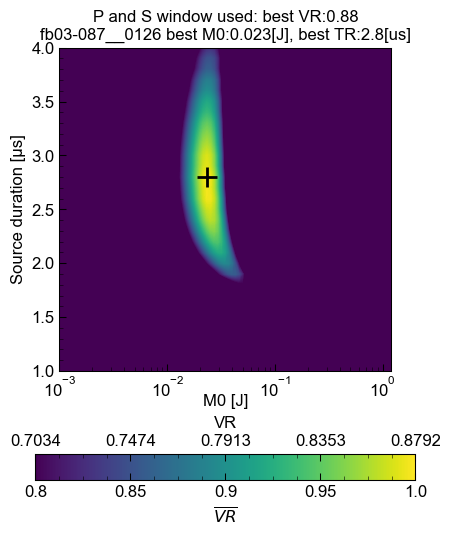

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.set_xscale('log')

contour_coef = 0.95 # plot contour line 
cmap="viridis"

vmax_PS = df_best_PS["VR_PS"].values[0] #0.6
vmin_PS = 0.8*vmax_PS

# Nlevel = np.hstack([-np.inf, np.linspace(vmin_PS, vmax_PS, 201)])
Nlevel = np.hstack([np.linspace(vmin_PS, vmax_PS, 201)])

h3 = ax.contourf(M0hat_range/np.sqrt(2), TR_range*1e6, zc_P.transpose(), Nlevel, vmin=vmin_PS, vmax=vmax_PS, cmap=cmap, extend='both')
# for c in h3.collections:
    # c.set_rasterized(True)
h3.set_rasterized(True)

ax.set_title(f"P and S window used: best VR:{vmax_PS:.2f}\n"+f"{datacase} best M0:{best_M0_PS:.3f}[J], best TR:{best_TR_PS*1e6:.1f}[us]", fontsize=12)
#     contour_level_P = [contour_coef*np.max(zc_P)]

ax.plot(best_M0_PS, best_TR_PS*1e6, "+", ms=15, c="k", markeredgewidth=2)

cb_PS = fig.colorbar(ScalarMappable(norm=h3.norm, cmap=h3.cmap), ax=ax, 
   ticks=np.linspace(vmin_PS, vmax_PS, 5), orientation="horizontal")
cb_PS.set_label("VR")

# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plot_twincbar(cb_PS, vmax_PS)

ax.set_xlim([1e-3, 1.2])
ax.set_xlabel("M0 [J]") 
ax.set_aspect(1.0, adjustable='box')
ax.xaxis.set_label_coords(0.5, -0.07)

ax.set_ylabel("Source duration [μs]") 
# plt.tight_layout()
plt.savefig(figdir + "/debug_VR_PS_{}_fix_ccshift_balldropmodel{}.png".format(datacase, balldrop_model), dpi=100)

In [47]:
vmin_PS, vmax_PS

(0.7033887562192083, 0.8792359452740103)

In [48]:
# save csv file
df_VR_all.to_csv(outputdir+"/MTinv_gridsearch_{}_balldropmodel{}_notebook.csv".format(datacase, balldrop_model), float_format="%.8f")

# save parameter file
fo = open(outputdir+"/GridSearch_param_{}_balldropmodel{}_notebook.pickle".format(datacase, balldrop_model),"wb")
pickle.dump(param,fo)
fo.close

<function BufferedWriter.close()>

This is the end of notebook.

Next, we postprocess the data and plot the convergence of source parameters.